In [1]:
import pandas as pd
import numpy as np

In [2]:
from dist import compute_AE_tanimoto_distance, compute_augmented_graph_distance
from dist import compute_embed3d_distance

## 1. Building High-Dimensional Probabilities (Weighted Graph)

In [3]:
from rdkit import Chem
smiles = "CNC(=O)c1cc(ccn1)Oc2ccc(cc2)NC(=O)Nc3ccc(c(c3)C(F)(F)F)Cl"
mol = Chem.MolFromSmiles(smiles)

In [4]:
D1 = compute_augmented_graph_distance(
    mol=mol,
    alpha=0.0,
    beta=10.0)
D2 = compute_AE_tanimoto_distance(
    mol=mol,
    radius=2, nBits=2048)

D3 = compute_embed3d_distance(
    mol=mol,)

[23:36:37] Molecule does not have explicit Hs. Consider calling AddHs()
[23:36:37] Molecule does not have explicit Hs. Consider calling AddHs()


In [5]:
dist = D1
n = dist.shape[0]

In [6]:
rho = [sorted(dist[i])[1] for i in range(dist.shape[0])]
#rho

In [7]:
def prob_high_dim(sigma, dist_row):
    """
    For each row of distance matrix (dist_row) compute
    probability in high dimensions (1D array)
    """
    d = dist[dist_row] - rho[dist_row]; d[d < 0] = 0
    return np.exp(- d / sigma)

def k(prob):
    """
    Compute n_neighbor = k (scalar) for each 1D array of high-dimensional probability
    """
    return np.power(2, np.sum(prob))

In [8]:
def sigma_binary_search(k_of_sigma, fixed_k):
    """
    Solve equation k_of_sigma(sigma) = fixed_k 
    with respect to sigma by the binary search algorithm
    """
    sigma_lower_limit = 0; sigma_upper_limit = 1000
    for i in range(20):
        approx_sigma = (sigma_lower_limit + sigma_upper_limit) / 2
        if k_of_sigma(approx_sigma) < fixed_k:
            sigma_lower_limit = approx_sigma
        else:
            sigma_upper_limit = approx_sigma
        if np.abs(fixed_k - k_of_sigma(approx_sigma)) <= 1e-5:
            break
    return approx_sigma

N_NEIGHBOR = 3
prob = np.zeros((n,n)); sigma_array = []
for dist_row in range(n):
    func = lambda sigma: k(prob_high_dim(sigma, dist_row))
    binary_search_result = sigma_binary_search(func, N_NEIGHBOR)
    prob[dist_row] = prob_high_dim(binary_search_result, dist_row)
    sigma_array.append(binary_search_result)
    if (dist_row + 1) % 100 == 0:
        print("Sigma binary search finished {0} of {1} cells".format(dist_row + 1, n))
print("\nMean sigma = " + str(np.mean(sigma_array)))


Mean sigma = 0.00095367431640625


### The symmetric matrix of high-dimensional probabilities

In [9]:
#P = (prob + np.transpose(prob)) / 2
P = prob + np.transpose(prob) - np.multiply(prob, np.transpose(prob))

In [10]:
P

array([[1.00000000e+000, 1.00000000e+000, 1.97734453e-020, ...,
        1.99682688e-124, 1.46524880e-096, 1.07518286e-068],
       [1.00000000e+000, 1.00000000e+000, 1.00000000e+000, ...,
        1.00989045e-104, 7.41046097e-077, 5.43771178e-049],
       [1.97734453e-020, 1.00000000e+000, 1.00000000e+000, ...,
        1.36976613e-080, 1.00511877e-052, 7.37544696e-025],
       ...,
       [1.99682688e-124, 1.00989045e-104, 1.36976613e-080, ...,
        1.00000000e+000, 1.00000000e+000, 2.72558064e-028],
       [1.46524880e-096, 7.41046097e-077, 1.00511877e-052, ...,
        1.00000000e+000, 1.00000000e+000, 1.00000000e+000],
       [1.07518286e-068, 5.43771178e-049, 7.37544696e-025, ...,
        2.72558064e-028, 1.00000000e+000, 1.00000000e+000]])

## 2. Building Low-Dimensional Probabilities (Weighted Graph)

In [11]:
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics.pairwise import euclidean_distances

model = SpectralEmbedding(n_components = 3, n_neighbors = N_NEIGHBOR, 
                          affinity = 'precomputed') #]

## 非监督的时候直接使用原子距离矩阵
dist_low = dist

#dist = squareform(mp.info_distance)
affinity_matrix  = np.exp(-(dist_low ** 2))

# Y就是原子初始化坐标 
Y = model.fit_transform(affinity_matrix) #
Y /= Y.max()

In [12]:
from scipy.optimize import curve_fit

In [13]:
MIN_DIST = 0.5

x = np.linspace(0, 3, 300)

def f(x, min_dist):
    y = []
    for i in range(len(x)):
        if(x[i] <= min_dist):
            y.append(1)
        else:
            y.append(np.exp(- x[i] + min_dist))
    return y

dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))

p , _ = curve_fit(dist_low_dim, x, f(x, MIN_DIST))

a = p[0]
b = p[1] 
print("Hyperparameters a = " + str(a) + " and b = " + str(b))

Hyperparameters a = 0.5830300205483709 and b = 1.334166992455648


In [14]:
def prob_low_dim(Y):
    """
    Compute matrix of probabilities v_ij in low-dimensional space
    """    
    inv_distances = np.power(1 + a * np.square(euclidean_distances(Y, Y))**b, -1)
    return inv_distances

In [15]:
def CE(P, Q):
    """
    Compute Cross-Entropy (CE) from matrix of high-dimensional probabilities 
    and coordinates of low-dimensional embeddings
    """
    Q = prob_low_dim(Y)
    return - P * np.log(Q + 0.01) - (1 - P) * np.log(1 - Q + 0.01)

def CE_gradient(P, Y):
    """
    Compute the gradient of Cross-Entropy (CE)
    """
    y_diff = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    inv_dist = np.power(1 + a * np.square(euclidean_distances(Y, Y))**b, -1)
    Q = np.dot(1 - P, np.power(0.001 + np.square(euclidean_distances(Y, Y)), -1))
    np.fill_diagonal(Q, 0)
    Q = Q / np.sum(Q, axis = 1, keepdims = True)
    fact=np.expand_dims(a*P*(1e-8 + np.square(euclidean_distances(Y, Y)))**(b-1) - Q, 2)
    return 2 * b * np.sum(fact * y_diff * np.expand_dims(inv_dist, 2), axis = 1)

Launch the Gradient Descent procedure:



In [16]:
lr = 1
epochs = 200

In [17]:
import matplotlib.pyplot as plt
from vis import visualize_molecule_with_coords
from vis import visualize_and_save_frame
import os
from render import render_html_to_image


In [18]:
# from render import render_html_to_image
# html_path = '1.html'
# output_path = 'rendered_output.png'

# render_html_to_image(html_path, output_path)


Cross-Entropy = 0.0047 after 0 iterations
Cross-Entropy = 0.0026 after 10 iterations
Cross-Entropy = 0.0020 after 20 iterations
Cross-Entropy = 0.0018 after 30 iterations
Cross-Entropy = 0.0019 after 40 iterations
Cross-Entropy = 0.0018 after 50 iterations
Cross-Entropy = 0.0017 after 60 iterations
Cross-Entropy = 0.0018 after 70 iterations
Cross-Entropy = 0.0017 after 80 iterations
Cross-Entropy = 0.0019 after 90 iterations
Cross-Entropy = 0.0016 after 100 iterations
Cross-Entropy = 0.0018 after 110 iterations
Cross-Entropy = 0.0017 after 120 iterations
Cross-Entropy = 0.0017 after 130 iterations
Cross-Entropy = 0.0016 after 140 iterations
Cross-Entropy = 0.0018 after 150 iterations
Cross-Entropy = 0.0017 after 160 iterations
Cross-Entropy = 0.0018 after 170 iterations
Cross-Entropy = 0.0015 after 180 iterations
Cross-Entropy = 0.0016 after 190 iterations


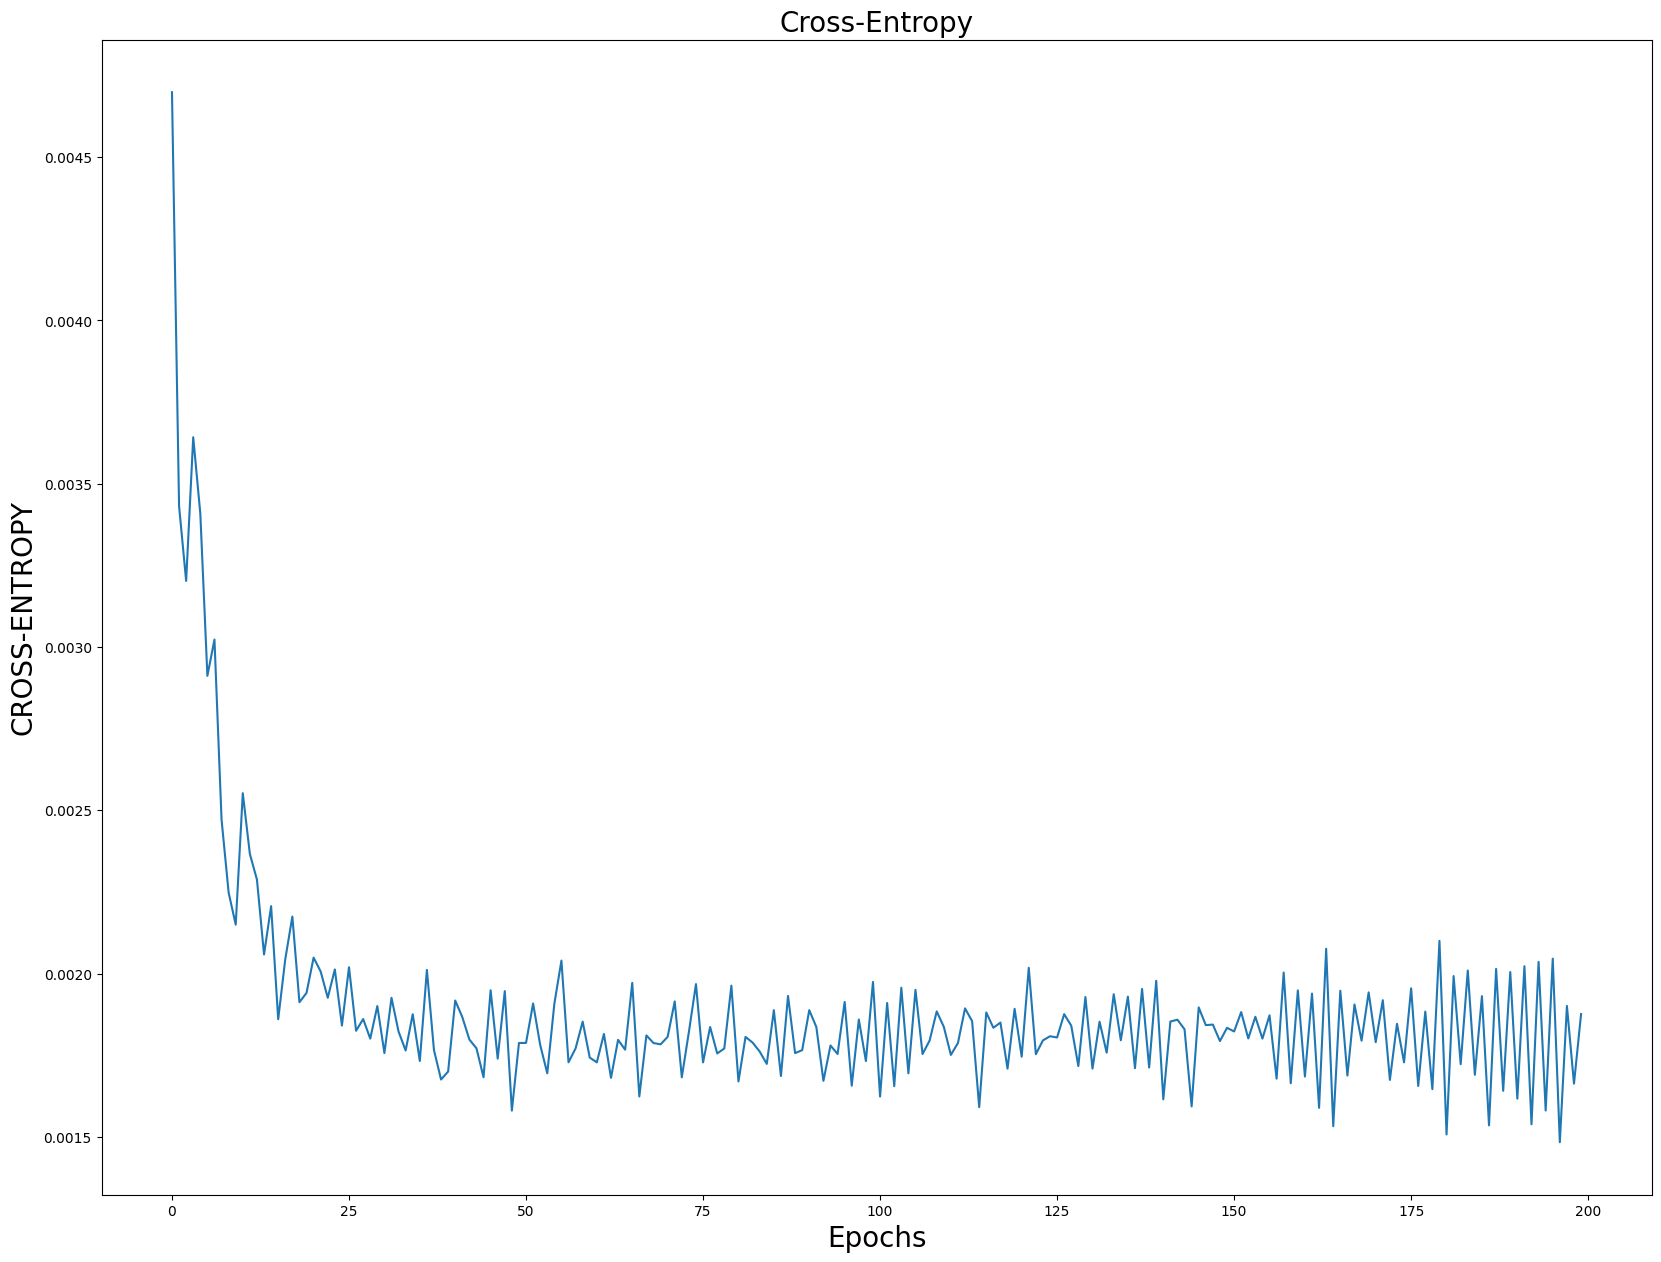

In [19]:
output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

CE_array = []
for i in range(epochs):
    Y = Y - lr * CE_gradient(P, Y)
    CE_current = np.sum(CE(P, Y)) / 1e+5
    CE_array.append(CE_current)

    # 保存每 10 轮一次图像帧
    if i % 10 == 0:
        print(f"Cross-Entropy = {CE_current:.4f} after {i} iterations")
        frame_path = os.path.join(output_dir, f"frame_{i:04d}")
        visualize_and_save_frame(smiles, Y, frame_path)

        render_html_to_image(frame_path+'.html', frame_path+'.png')






plt.figure(figsize=(20,15))
plt.plot(CE_array)
plt.title("Cross-Entropy", fontsize = 20)
plt.xlabel("Epochs", fontsize = 20); plt.ylabel("CROSS-ENTROPY", fontsize = 20)
plt.show()

In [20]:
visualize_molecule_with_coords(smiles, Y)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [28]:
from vis import make_video_from_frames
make_video_from_frames("frames", "optimization.mp4", fps=5)

In [29]:
from IPython.display import Video
# 直接播放当前目录下的视频
Video("optimization.mp4", embed=True, width=600, height=400)

In [23]:
from dist2coords import coords2dict_mds, coords2dict_tch

## 从pairwise欧式距离还原为坐标

In [24]:
Y = coords2dict_mds(D3)
visualize_molecule_with_coords(smiles, Y)

/home/shenwanxiang/anaconda3/envs/clsar/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [25]:
Y = coords2dict_tch(D3)
visualize_molecule_with_coords(smiles, Y)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [26]:
from rdkit import Chem
from rdkit.Chem import Draw

def draw_mol_with_indices(smiles):
    mol = Chem.MolFromSmiles(smiles)
    for atom in mol.GetAtoms():
        atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))  # 设置原子编号为标签

    return Draw.MolToImage(mol, size=(300, 300))


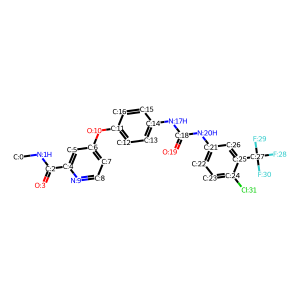

In [27]:
draw_mol_with_indices(smiles)

In [33]:
from moviepy.editor import VideoFileClip
from PIL import Image

# 修复 ANTIALIAS 的兼容性
if not hasattr(Image, 'ANTIALIAS'):
    Image.ANTIALIAS = Image.Resampling.LANCZOS

# 转换视频
clip = VideoFileClip("optimization.mp4").subclip(0, 5)  # 裁剪前5秒
clip = clip.resize(height=300)  # 缩小尺寸
clip.write_gif("optimization.gif", fps=10)  # 保存为GIF


MoviePy - Building file optimization.gif with imageio.
